# BETA REGRESSION

## Load libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit

In [2]:
az.style.use("arviz-darkgrid")

## Simulate beta distribution

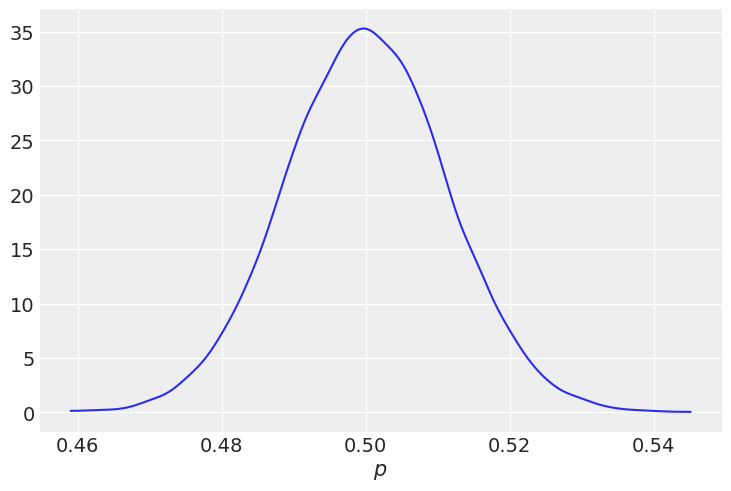

In [3]:
alpha = 1_000
beta = 1_000
p = np.random.beta(alpha, beta, size=10_000)
az.plot_kde(p)
plt.xlabel("$p$");

In [4]:
data = pd.DataFrame({"probabilities": p})
model = bmb.Model("probabilities ~ 1", data, family="beta")
fitted = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [probabilities_kappa, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


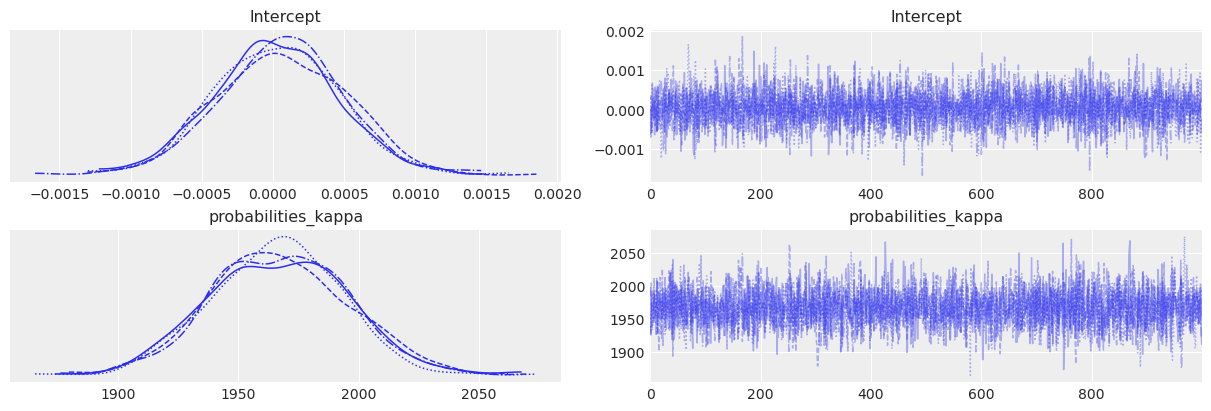

In [5]:
az.plot_trace(fitted);

In [6]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.000,0.000,-0.001,0.001,0.000,0.00,4051.0,3234.0,1.0
probabilities_kappa,1966.635,28.065,1916.377,2020.373,0.439,0.31,4133.0,3109.0,1.0


In [7]:
def mukappa_to_alphabeta(mu, kappa):
    # Calculate alpha and beta
    alpha = mu * kappa
    beta = (1 - mu) * kappa
    
    # Get mean values and 95% HDIs 
    alpha_mean = alpha.mean(("chain", "draw")).item()
    alpha_hdi = az.hdi(alpha, hdi_prob=.95)["x"].values
    beta_mean = beta.mean(("chain", "draw")).item()
    beta_hdi = az.hdi(beta, hdi_prob=.95)["x"].values
    
    return alpha_mean, alpha_hdi, beta_mean, beta_hdi

alpha, alpha_hdi, beta, beta_hdi = mukappa_to_alphabeta(
    expit(fitted.posterior["Intercept"]),
    fitted.posterior["probabilities_kappa"]
)

print(f"Alpha - mean: {np.round(alpha)}, 95% HDI: {np.round(alpha_hdi[0])} - {np.round(alpha_hdi[1])}")
print(f"Beta - mean: {np.round(beta)}, 95% HDI: {np.round(beta_hdi[0])} - {np.round(beta_hdi[1])}")

Alpha - mean: 983.0, 95% HDI: 956.0 - 1011.0
Beta - mean: 983.0, 95% HDI: 956.0 - 1010.0


In [8]:
def mukappa_to_alphabeta(mu, kappa):
    # Calculate alpha and beta
    alpha = mu * kappa
    beta = (1 - mu) * kappa
    
    # Get mean values and 95% HDIs 
    alpha_mean = alpha.mean(("chain", "draw")).item()
    alpha_hdi = az.hdi(alpha, hdi_prob=.95)["x"].values
    beta_mean = beta.mean(("chain", "draw")).item()
    beta_hdi = az.hdi(beta, hdi_prob=.95)["x"].values
    
    return alpha_mean, alpha_hdi, beta_mean, beta_hdi

alpha, alpha_hdi, beta, beta_hdi = mukappa_to_alphabeta(
    expit(fitted.posterior["Intercept"]),
    fitted.posterior["probabilities_kappa"]
)

print(f"Alpha - mean: {np.round(alpha)}, 95% HDI: {np.round(alpha_hdi[0])} - {np.round(alpha_hdi[1])}")
print(f"Beta - mean: {np.round(beta)}, 95% HDI: {np.round(beta_hdi[0])} - {np.round(beta_hdi[1])}")

Alpha - mean: 983.0, 95% HDI: 956.0 - 1011.0
Beta - mean: 983.0, 95% HDI: 956.0 - 1010.0


## Beta regression with predictors

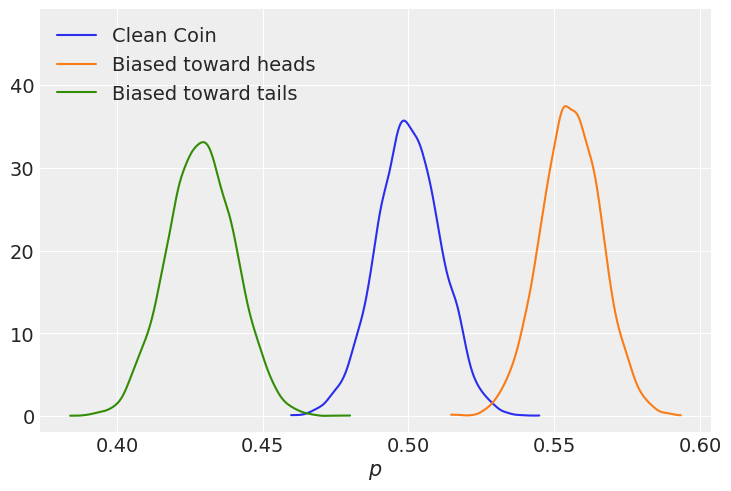

In [9]:
effect_per_micron = 5.0

# Clean Coin
alpha = 1_000
beta = 1_000
p = np.random.beta(alpha, beta, size=10_000)

# Add two std to tails side (heads more likely)
p_heads = np.random.beta(alpha + 50 * effect_per_micron, beta, size=10_000)
# Add two std to heads side (tails more likely)
p_tails = np.random.beta(alpha - 50 * effect_per_micron, beta, size=10_000)

az.plot_kde(p, label="Clean Coin")
az.plot_kde(p_heads, label="Biased toward heads", plot_kwargs={"color":"C1"})
az.plot_kde(p_tails, label="Biased toward tails", plot_kwargs={"color":"C2"})
plt.xlabel("$p$")
plt.ylim(top=plt.ylim()[1]*1.25);

In [10]:
# Create amount of dirt on top and bottom
heads_bias_dirt = stats.halfnorm(loc=0, scale=25).rvs(size=1_000)
tails_bias_dirt = stats.halfnorm(loc=0, scale=25).rvs(size=1_000)

# Create the probability per coin
alpha = np.repeat(1_000, 1_000)
alpha = alpha + effect_per_micron * heads_bias_dirt - effect_per_micron * tails_bias_dirt
beta = np.repeat(1_000, 1_000)

p = np.random.beta(alpha, beta)

df = pd.DataFrame({
    "p" : p,
    "heads_bias_dirt" : heads_bias_dirt.round(),
    "tails_bias_dirt" : tails_bias_dirt.round()
})
df.head()

,p,heads_bias_dirt,tails_bias_dirt
0,0.540996,37.0,0.0
1,0.470550,11.0,34.0
2,0.523000,26.0,2.0
3,0.561050,51.0,4.0
4,0.526684,17.0,10.0


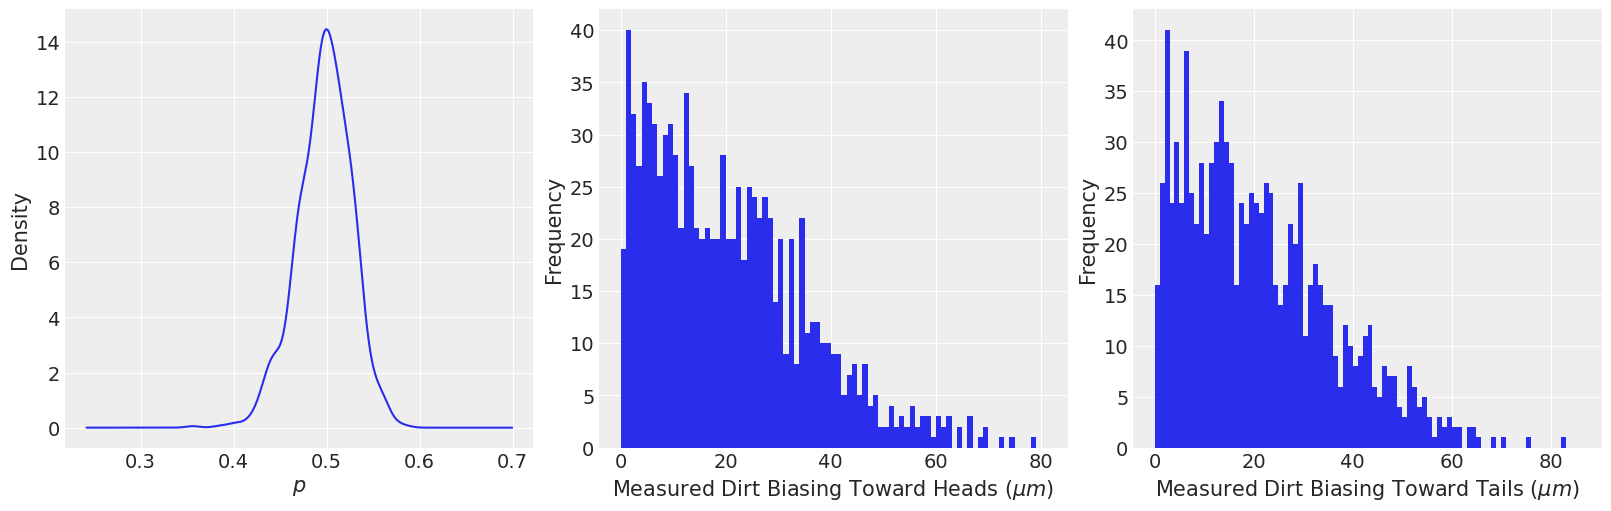

In [11]:
fig,ax = plt.subplots(1,3, figsize=(16,5))

df["p"].plot.kde(ax=ax[0])
ax[0].set_xlabel("$p$")

df["heads_bias_dirt"].plot.hist(ax=ax[1], bins=np.arange(0,df["heads_bias_dirt"].max()))
ax[1].set_xlabel("Measured Dirt Biasing Toward Heads ($\mu m$)")
df["tails_bias_dirt"].plot.hist(ax=ax[2], bins=np.arange(0,df["tails_bias_dirt"].max()))
ax[2].set_xlabel("Measured Dirt Biasing Toward Tails ($\mu m$)");

In [12]:
df["delta_d"] = df["heads_bias_dirt"] - df["tails_bias_dirt"]
dirt_model = bmb.Model("p ~ delta_d", df, family="beta")
dirt_fitted = dirt_model.fit()
dirt_model.predict(dirt_fitted, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_kappa, Intercept, delta_d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


In [13]:
az.summary(dirt_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.006,0.002,-0.009,-0.003,0.000,0.000,6615.0,3359.0,1.0
delta_d,0.005,0.000,0.005,0.005,0.000,0.000,6295.0,3278.0,1.0
p_kappa,1802.922,78.885,1659.299,1955.359,0.922,0.652,7299.0,3347.0,1.0
p_mean[0],0.544,0.001,0.543,0.546,0.000,0.000,6245.0,3195.0,1.0
p_mean[1],0.470,0.001,0.469,0.471,0.000,0.000,6383.0,3214.0,1.0
...,...,...,...,...,...,...,...,...,...
p_mean[995],0.506,0.000,0.505,0.507,0.000,0.000,6476.0,3275.0,1.0
p_mean[996],0.496,0.000,0.495,0.497,0.000,0.000,6543.0,3371.0,1.0
p_mean[997],0.482,0.000,0.481,0.483,0.000,0.000,6244.0,2986.0,1.0
p_mean[998],0.503,0.000,0.503,0.504,0.000,0.000,6551.0,3218.0,1.0


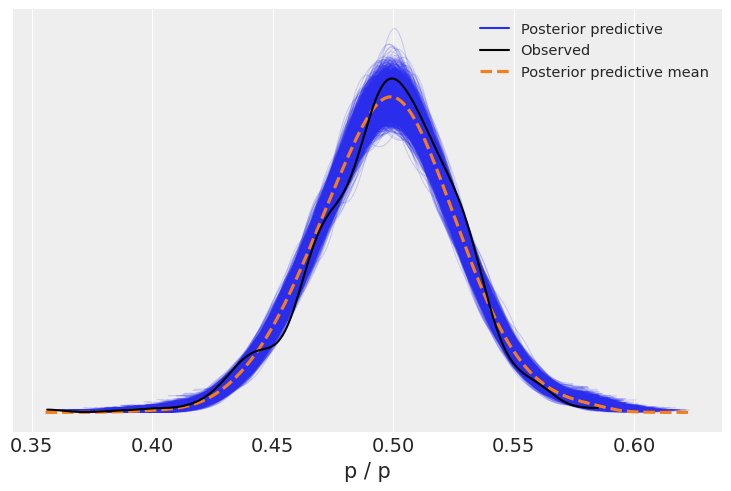

In [14]:
az.plot_ppc(dirt_fitted);

In [15]:
mean_effect = expit(dirt_fitted.posterior.delta_d.mean())
hdi = az.hdi(dirt_fitted.posterior.delta_d, hdi_prob=.95)
lower = expit(hdi.delta_d[0])
upper = expit(hdi.delta_d[1])
print(f"Mean effect: {mean_effect.item():.4f}")
print(f"95% interval {lower.item():.4f} - {upper.item():.4f}")

Mean effect: 0.5012
95% interval 0.5012 - 0.5013


## Revisiting baseball data

In [16]:
batting = bmb.load_data("batting")

In [17]:
batting["batting_avg"] = batting["H"] / batting["AB"]
batting = batting[batting["AB"] > 100]
df = batting[ (batting["yearID"] > 1990) & (batting["yearID"] < 2018) ]

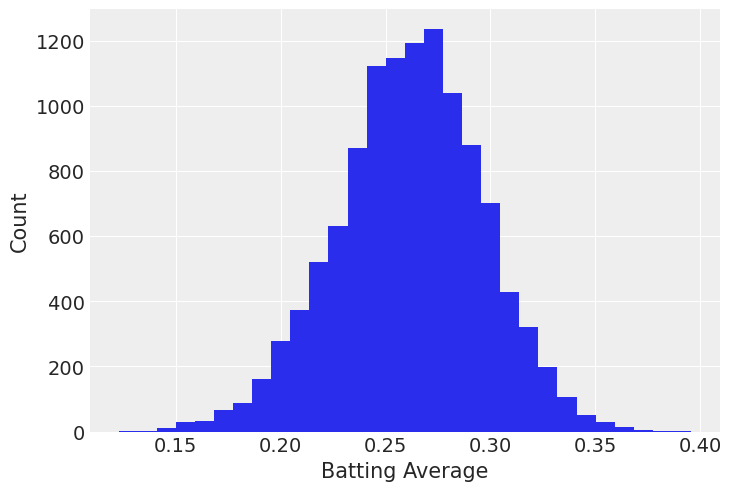

In [18]:
df.batting_avg.hist(bins=30)
plt.xlabel("Batting Average")
plt.ylabel("Count");

In [19]:
model_avg = bmb.Model("batting_avg ~ 1", df, family="beta")
avg_fitted = model_avg.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batting_avg_kappa, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [20]:
az.summary(avg_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.038,0.002,-1.041,-1.035,0.000,0.000,4355.0,2884.0,1.0
batting_avg_kappa,152.586,2.018,148.703,156.313,0.031,0.022,4228.0,3009.0,1.0


In [21]:
posterior_predictive = model_avg.predict(avg_fitted, kind="pps")

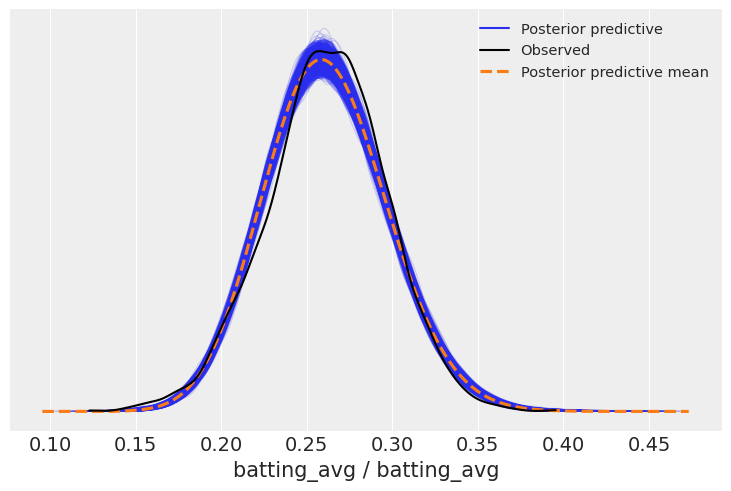

In [22]:
az.plot_ppc(avg_fitted);

In [23]:
# Add the player's batting average in the n-1 year
batting["batting_avg_shift"] = np.where(
    batting["playerID"] == batting["playerID"].shift(),
    batting["batting_avg"].shift(),
    np.nan
)
df_shift = batting[ (batting["yearID"] > 1990) & (batting["yearID"] < 2018) ]
df_shift = df_shift[~df_shift["batting_avg_shift"].isna()]
df_shift[["batting_avg_shift","batting_avg"]].corr()

,batting_avg_shift,batting_avg
batting_avg_shift,1.000000,0.229774
batting_avg,0.229774,1.000000


In [24]:
model_avg = bmb.Model("batting_avg ~ 1", df_shift, family="beta")
avg_fitted = model_avg.fit(idata_kwargs={"log_likelihood": True})

model_lag = bmb.Model("batting_avg ~ batting_avg_shift", df_shift, family="beta")
lag_fitted = model_lag.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batting_avg_kappa, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batting_avg_kappa, Intercept, batting_avg_shift]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


In [25]:
az.compare({
    "intercept-only" : avg_fitted,
    "lag-model": lag_fitted
})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
lag-model,0,785.092511,2.937449,0.000000,0.99826,14.528744,0.000000,False,log
intercept-only,1,774.112216,2.125852,10.980294,0.00174,15.348322,4.663777,False,log


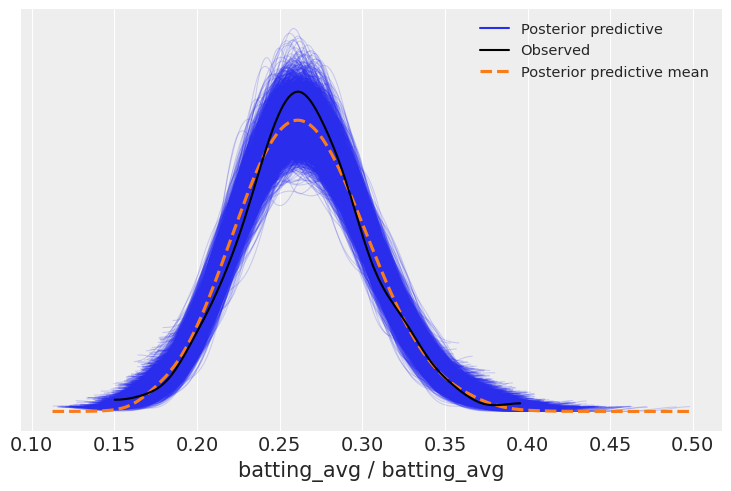

In [26]:
ppc= model_lag.predict(lag_fitted, kind="pps")
az.plot_ppc(lag_fitted);